# Wildfire Damage Assessment (binary classification)

In [1]:
#First rescale data to minmax and convert to uint8
#!gdal_translate -scale 0 13016 0 255 -ot Byte data/SantaRosa/Sent2/post/B08_clip_post.tif data/SantaRosa/Sent2/post/B08_clip_scale_post.tif

Input file size is 876, 871
0...10...20...30...40...50...60...70...80...90...100 - done.


In [2]:
#!gdal_translate -scale 0 13016 0 255 -ot Byte data/SantaRosa/Sent2/pre/B08_clip_pre.tif data/SantaRosa/Sent2/pre/B08_clip_scale_pre.tif

Input file size is 876, 871
0...10...20...30...40...50...60...70...80...90...100 - done.


In [7]:
%load_ext autoreload

In [8]:
from wildfireassessment.ops import * #my package
from wildfireassessment.plots import * #my package
#from wildfireassessment.test import *
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import morphology
from skimage.transform import resize
import pandas as pd
import geopandas as gpd
import pickle
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.externals import joblib
from rasterstats import zonal_stats
import fiona
%matplotlib inline

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [13]:
#read in filepaths for data

#filepath_post = 
#filepath_pre = Path("./data/SantaRosa/WorldView/pre")

#WorldView Post/Pre
fps_wv_post = Path("./data/SantaRosa/WorldView/post/0221213.tif")
fps_wv_pre = Path("./data/SantaRosa/WorldView/pre/0221213_2.tif")

#Sent2 Post/Pre
fps_sent2_post = Path("./data/SantaRosa/Sent2/post/B08_clip_scale_post.tif")
fps_sent2_pre = Path("./data/SantaRosa/Sent2/pre/B08_clip_scale_pre.tif")

In [14]:
raster_src_post, rgb_post = readRGBImg(fps_wv_post)
raster_src_pre, rgb_pre = readRGBImg(fps_wv_pre)

In [15]:
raster_src_post_b08, b08_post = readOneImg(fps_sent2_post)
raster_src_pre_b08, b08_pre = readOneImg(fps_sent2_pre)

In [16]:
b08_upscaled_post = resize(b08_post, raster_src_post.shape, anti_aliasing=True)
b08_upscaled_post = b08_upscaled_post * 255
b08_upscaled_post = b08_upscaled_post.astype(rasterio.uint8)

In [17]:
b08_upscaled_pre = resize(b08_pre, raster_src_pre.shape, anti_aliasing=True)
b08_upscaled_pre = b08_upscaled_pre * 255
b08_upscaled_pre = b08_upscaled_pre.astype(rasterio.uint8)

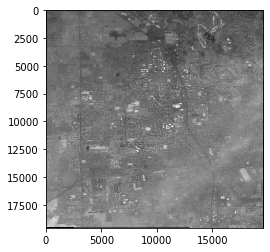

In [18]:
plt.imshow(b08_upscaled_post, cmap='gray')

## Extract pixels

#### unravel

In [19]:
rgb_rav_post = {0 : rgb_post[:,:,0].ravel().astype(float),
                1 : rgb_post[:,:,1].ravel().astype(float),
                2 : rgb_post[:,:,2].ravel().astype(float)}
rgb_rav_pre = {0 : rgb_pre[:,:,0].ravel().astype(float),
               1 : rgb_pre[:,:,1].ravel().astype(float),
               2 : rgb_pre[:,:,2].ravel().astype(float)}

In [20]:
b08_rav_post = b08_upscaled_post.ravel().astype(float)
b08_rav_pre = b08_upscaled_pre.ravel().astype(float)

In [21]:
b08_rav_pre.shape[0]

383533056

In [22]:
b08_upscaled_post = None
b08_upscaled_pre = None
b08_post = None
b08_pre = None
rgb_pre = None
rgb_post = None

In [23]:
def computeSI(b1, b2):
    return (b1-b2)/(b1+b2)

def changedSI(SI_pre, SI_post):
    return SI_pre - SI_post

In [24]:
def makeChunkX(b, g, r, n, b_p, g_p, r_p, n_p):
    SI_gb = (computeSI(g, b), computeSI(g_p, b_p)) #(post, pre)
    SI_rb = (computeSI(r, b), computeSI(r_p, b_p))
    SI_rg = (computeSI(r, g), computeSI(r_p, g_p))
    SI_nb = (computeSI(n, b), computeSI(n_p, b_p))
    SI_ng = (computeSI(n, g), computeSI(n_p, g_p))
    SI_nr = (computeSI(n, r), computeSI(n_p, r_p))
    
    dSI_gb = changedSI(SI_gb[1], SI_gb[0])
    dSI_rb = changedSI(SI_rb[1], SI_rb[0])
    dSI_rg = changedSI(SI_rg[1], SI_rg[0])
    dSI_nb = changedSI(SI_nb[1], SI_nb[0])
    dSI_ng = changedSI(SI_ng[1], SI_ng[0])
    dSI_nr = changedSI(SI_nr[1], SI_nr[0])
    
    return np.dstack((b, b_p, g, g_p, r, r_p, n, n_p,
                      SI_gb[0], SI_rb[0], SI_rg[0], SI_nb[0], SI_ng[0], SI_nr[0],
                      SI_gb[1], SI_rb[1], SI_rg[1], SI_nb[1], SI_ng[1], SI_nr[1],
                      dSI_nb, dSI_rg, dSI_rb, dSI_gb, dSI_nr, dSI_ng))[0]

In [25]:
X_chunk = makeChunkX(rgb_rav_post[2][0:100], rgb_rav_post[1][0:100], rgb_rav_post[0][0:100], b08_rav_post[0:100],
           rgb_rav_pre[2][0:100], rgb_rav_pre[1][0:100], rgb_rav_pre[0][0:100], b08_rav_pre[0:100])

In [26]:
m = ma.masked_invalid(X_chunk)
ma.set_fill_value(m, -999)
m

masked_array(
  data=[[113.0, 68.0, 141.0, ..., -0.010898472128070089, 0.0, 0.0],
        [117.0, 75.0, 146.0, ..., -0.00846975251018875, 0.0, 0.0],
        [124.0, 81.0, 154.0, ..., -0.007913669064748191, 0.0, 0.0],
        ...,
        [101.0, 101.0, 127.0, ..., -0.03221690590111642,
         0.1536563006840138, 0.1623043899736879],
        [100.0, 101.0, 127.0, ..., -0.037124549459351217,
         0.147711858356536, 0.1623043899736879],
        [100.0, 103.0, 127.0, ..., -0.03858558842039017,
         0.1369968768642313, 0.15512048192771088]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-999.0)

In [27]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_chunk)
X_chunk_imp = imp.transform(X_chunk)

In [28]:
rf_model = joblib.load(open("models/rf_grid_bin_precision.pkl", 'rb'))

In [29]:
pred_y = rf_model.predict(X_chunk_imp)

### Test Random Forest

In [30]:
from joblib import Parallel, delayed
import multiprocessing

def processInParallel(i):
    X_chunk = makeChunkX(rgb_rav_post[2][i:i+100], rgb_rav_post[1][i:i+100], rgb_rav_post[0][i:i+100], b08_rav_post[i:i+100],
           rgb_rav_pre[2][i:i+100], rgb_rav_pre[1][i:i+100], rgb_rav_pre[0][i:i+100], b08_rav_pre[i:i+100])
    
    return rf_model.predict(ma.masked_invalid(X_chunk))

In [31]:
%%time
num_cores = multiprocessing.cpu_count()
pred_y = Parallel(n_jobs=num_cores, backend="multiprocessing")(delayed(processInParallel)(i) for i in range(0, len(b08_rav_post), 100))
pred_y

CPU times: user 1min 48s, sys: 15.6 s, total: 2min 4s
Wall time: 11min 29s


[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [32]:
pred_y_rf = np.hstack(pred_y).reshape(raster_src_post.shape)

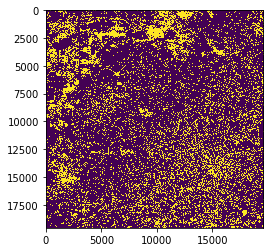

In [33]:
plt.imshow(pred_y_rf)

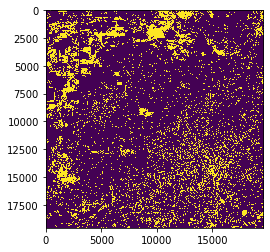

In [34]:
pred_y_rf_clean = morphology.remove_small_holes(pred_y_rf==1, 500) 
pred_y_rf_clean = morphology.remove_small_objects(pred_y_rf_clean, 500)
plt.imshow(pred_y_rf_clean)

In [35]:
pred_y_rf_clean.astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [36]:
raster_src_post.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 19584,
 'height': 19584,
 'count': 3,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(4.487879136029412e-06, 0.0, -122.783203125,
        0.0, -4.487879136029412e-06, 38.49609375)}

In [37]:
metadata = {
    'driver': 'GTiff',
    'dtype': 'uint8',
    'width': raster_src_post.meta['width'], 
    'height': raster_src_post.meta['height'],
    'count': 1,
    'crs': raster_src_post.meta['crs'], 
    'transform': raster_src_post.meta['transform']
}
metadata

{'driver': 'GTiff',
 'dtype': 'uint8',
 'width': 19584,
 'height': 19584,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(4.487879136029412e-06, 0.0, -122.783203125,
        0.0, -4.487879136029412e-06, 38.49609375)}

In [38]:
with rasterio.open("results/predict_mask_rf_SantaRosa_0221213.tif", 'w', **metadata) as dst:
    dst.write(pred_y_rf_clean.astype(np.uint8), 1)